# Regressão Logística
Neste notebook, será testado um modelo de regressão logística para classificar indivíduos como Control (saudáveis) ou Impaired (afetados) de acordo com seus níveis de biomarcadores. A regressão logística separa dados em duas ou mais categorias utilizando a função logística, que possui um formato de S que permite a separação dos indivíduos. 

A métrica usada para seleção de atributos, otimização de hiperparâmetros e validação cruzada será a f1-score.

In [18]:
# Bibliotecas
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from optuna import create_study
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

## Importando dados:
Aqui os dados serão importados e devidamente manipulados. Como consequência da exportação dos arquivos csv feita pelo código do tratamento geral, surge uma coluna que carrega os índices de cada fileira. Como não queremos que esta interfira em qualquer procedimento de nosso modelo, vamos excluí-la. 

Como nosso target é categórico binário, devemos codificá-lo em 0 e 1 para que nosso modelo funcione. O valor 'Control' será codificado como 0 e o valor 'Impaired' será codificado como 1.

In [19]:
# Importando dados
features = pd.read_csv("Features para treino.csv")
features = features.drop("Unnamed: 0", axis=1)

target = pd.read_csv("Target para treino.csv")
target = target["Class"]
features = features.values

X_teste = pd.read_csv("Features para teste.csv")
X_teste = X_teste.drop("Unnamed: 0", axis=1)
y_teste = pd.read_csv("Target para teste.csv")["Class"]

In [20]:
#Normalizando o target:
le = LabelEncoder()
nle = LabelEncoder()
target = le.fit_transform(target)
y_teste = nle.fit_transform(y_teste)

## Otimização de hiperparâmetros:
Diferentemente do que acontece com outros tipos de modelo, os hiperparâmetros da regressão logística influenciam fundamentalmente no funcionamento dos modelos, além de que alguns hiperparâmetros são dependentes de outros para funcionar, o que diminui a variedade de modelos que podemos testar.

Os hiperparâmetros testados foram: 

C: o inverso da força da regularização. Quanto menor, mais forte será a penalidade aplicada.

Penalty: é o tipo de regularização aplicada aos dados. Neste caso, foi padronizada a regularização ridge (l2).

Solver: é o algoritmo usado para a otimização do modelo. Depende do tamanho do dataset e da regularização aplicada.

Max iter: é o número máximo de iterações que o modelo pode realizar para tentar convergir uma estimativa. Apesar deste valor ter sido otimizado, foi necessário defini-lo como 10000 arbitrariamente pois o valor sugerido pelo optuna não foi suficiente para rodar o modelo com os dados.

In [21]:
# Preparando a otimização de hiperparâmetros com optuna
#Criando as funções auxiliares
def instancia_geral(trial, parametros, algoritmo):
    modelo = algoritmo(**parametros)
    return modelo

def objetivo_geral(trial, parametros, algoritmo):
    modelo = instancia_geral(trial, parametros, algoritmo)
    metricas = cross_val_score(
        modelo,
        features,
        target,
        scoring="f1",
        cv= 5,
        n_jobs=-1
    )
    return metricas.mean()


def funcao_objetivo_parcial_log_reg(trial):
    parametros = {'C': trial.suggest_float('C', 1e-6, 1e+2, log=True),
                  'penalty': trial.suggest_categorical('penalty', ["l2"]),
                  'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga', "liblinear"]),
                  'max_iter': trial.suggest_int('max_iter', 100, 10000)}
    return objetivo_geral(trial, parametros, LogisticRegression)

In [23]:
NOME_DO_ESTUDO = "log_reg6"
estudo_knn = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

estudo_knn.optimize(funcao_objetivo_parcial_log_reg, n_trials=150)

[I 2025-11-03 20:00:42,318] A new study created in RDB with name: log_reg6
[I 2025-11-03 20:00:48,632] Trial 0 finished with value: 0.3101515151515152 and parameters: {'C': 0.0018173692344649903, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 8888}. Best is trial 0 with value: 0.3101515151515152.
[I 2025-11-03 20:00:53,184] Trial 1 finished with value: 0.11278195488721802 and parameters: {'C': 0.00035674298599936864, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 3630}. Best is trial 0 with value: 0.3101515151515152.
[I 2025-11-03 20:00:57,757] Trial 2 finished with value: 0.0 and parameters: {'C': 4.430451176980301e-06, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 8290}. Best is trial 0 with value: 0.3101515151515152.
[I 2025-11-03 20:00:58,008] Trial 3 finished with value: 0.7114580368545885 and parameters: {'C': 13.833917711390365, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 2145}. Best is trial 3 with value: 0.7114580368545885.
[I 2025-11-03 20:00:59,504] Trial 4 fin

## Seleção de atributos:
Nesta parte do código, executaremos a seleção de atributos de nossas features. Utilizaremos o algoritmo de Seleção Sequencial de Atributos, que calcula a importância de cada coluna para o resultado do modelo e retira as colunas que não são interessantes para análise. 

In [24]:
params = estudo_knn.best_trial.params
params["max_iter"] = 10000
# Selecionando features
from sklearn.feature_selection import SequentialFeatureSelector

modelo = LogisticRegression(**params)
seletor = SequentialFeatureSelector(
    modelo,
    n_features_to_select="auto",
    direction="backward",
    scoring="f1",
    cv = 5,
    n_jobs=-1
)
seletor.fit(features, target)

X_treino_modificado = seletor.transform(features)
X_teste_modificado = seletor.transform(X_teste)

print(f"Número original de atributos: {seletor.n_features_in_}")
print(f"Número de atributos selecionados: {seletor.n_features_to_select_}")
print(f"Colunas selecionadas: {seletor.support_}")

Número original de atributos: 134
Número de atributos selecionados: 67
Colunas selecionadas: [False False False False False False  True  True False False False  True
 False False False False  True False False False False False  True  True
 False False  True False False False False  True False  True False  True
 False  True False  True False False  True False  True False  True False
 False False  True False False False False  True False False False  True
  True False  True False  True False False False  True False False False
 False False  True  True  True False False  True  True  True  True  True
  True  True  True False  True False False  True  True  True False False
  True False  True False  True  True False False  True  True  True  True
  True False  True  True False  True  True  True False  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True]


C:\Users\vitor25023\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SequentialFeatureSelector was fitted without feature names
  warnings.warn(


## Execução e validação cruzada do modelo: 
Aqui, será instanciado um modelo LogisticRegression com os hiperparâmetros selecionados pelo Optuna. O modelo será treinado com os conjuntos de dados de treino e em seguida, será testado com os dados de teste. 

Primeiro, será calculada a acurácia do modelo, em seguida, será feita uma validação cruzada para estimar a sensitividade do modelo.

In [27]:
predictor = LogisticRegression(**params)
predictor.fit(X_treino_modificado, target)
y_pred = predictor.predict(X_teste_modificado)
accuracy = accuracy_score(y_teste, y_pred)
print(accuracy)

y_pred_trans = le.inverse_transform(y_pred)

medida = cross_val_score(predictor, X_teste_modificado, y_teste, scoring="f1", cv=5)
print("F1 médio no conjunto de teste:", medida.mean())

acuracia = cross_val_score(predictor, X_teste_modificado, y_teste, scoring="accuracy", cv=5)
print("Acurácia média no conjunto de teste:", acuracia.mean())

0.8928571428571429
F1 médio no conjunto de teste: 0.6233333333333333
Acurácia média no conjunto de teste: 0.7970588235294117


['Control' 'Impaired']


<Axes: >

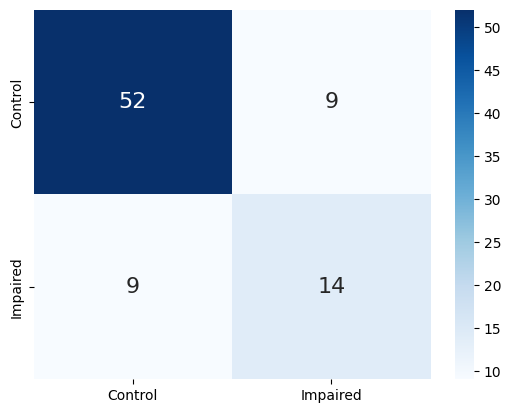

In [ ]:
#Montando a matriz de confusão 
classes = np.unique(y_pred_trans)
Y = nle.inverse_transform(y_teste)
print(classes)
cm = confusion_matrix(Y, y_pred_trans, labels=classes)
df_conf = pd.DataFrame(cm, classes, classes)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, cmap="Blues")

In [ ]:
print(classification_report(Y, y_pred_trans))

              precision    recall  f1-score   support

     Control       0.85      0.85      0.85        61
    Impaired       0.61      0.61      0.61        23

    accuracy                           0.79        84
   macro avg       0.73      0.73      0.73        84
weighted avg       0.79      0.79      0.79        84



Uma informação importante que a regressão logística fornece é a probabilidade atribuída a cada previsão, o que nos permite ter uma visão da "certeza" que o modelo tem de cada decisão tomada:

In [ ]:
probabilidades = predictor.predict_proba(X_teste_modificado)
for nome_p, nome_v, prob_ in zip(y_pred, y_teste, probabilidades):
    print(
        f"Era {nome_v} e previu {nome_p}. "
        f"Prob. de ser {nome_p}: {prob_[nome_p]:.3f}."
    )

Era 1 e previu 0. Prob. de ser 0: 0.797.
Era 0 e previu 0. Prob. de ser 0: 0.999.
Era 0 e previu 0. Prob. de ser 0: 1.000.
Era 0 e previu 1. Prob. de ser 1: 0.849.
Era 1 e previu 0. Prob. de ser 0: 0.666.
Era 1 e previu 1. Prob. de ser 1: 1.000.
Era 0 e previu 0. Prob. de ser 0: 1.000.
Era 0 e previu 0. Prob. de ser 0: 0.985.
Era 0 e previu 0. Prob. de ser 0: 0.973.
Era 0 e previu 1. Prob. de ser 1: 0.880.
Era 0 e previu 0. Prob. de ser 0: 1.000.
Era 1 e previu 1. Prob. de ser 1: 0.996.
Era 1 e previu 1. Prob. de ser 1: 0.925.
Era 1 e previu 1. Prob. de ser 1: 0.949.
Era 1 e previu 1. Prob. de ser 1: 0.999.
Era 0 e previu 0. Prob. de ser 0: 0.555.
Era 0 e previu 0. Prob. de ser 0: 1.000.
Era 0 e previu 0. Prob. de ser 0: 1.000.
Era 0 e previu 0. Prob. de ser 0: 1.000.
Era 0 e previu 0. Prob. de ser 0: 1.000.
Era 1 e previu 1. Prob. de ser 1: 0.998.
Era 0 e previu 0. Prob. de ser 0: 1.000.
Era 1 e previu 1. Prob. de ser 1: 1.000.
Era 1 e previu 1. Prob. de ser 1: 0.871.
Era 1 e previu 1

## Resultados e conclusão:
Este modelo tem uma acurácia de 0.797, ligeiramente maior que a do NaiveBayes, e analisando o classification_report, seu recall e precisão para identificação de indivíduos afetados também são menores (curiosamente, ambas as métricas têm o valor de 0.61), logo, o f1-score da métrica também será o mesmo.

Analisando o f1-score médio da validação cruzada, temos o valor de 0.623.

## Referências:
1. GUIMARÃES, Nara. *Regressão Logística: Como usá-la em análise de dados*. Medium, 2023 (aproximadamente). Disponível em: [https://medium.com/@nara.guimaraes/regress%C3%A3o-log%C3%ADstica-como-usu%C3%A1-la-em-an%C3%A1lise-de-dados-3fdb6be3a255](https://medium.com/@nara.guimaraes/regress%C3%A3o-log%C3%ADstica-como-usu%C3%A1-la-em-an%C3%A1lise-de-dados-3fdb6be3a255). Acesso em: 3 nov. 2025. ([Medium][1])

2. SCIKIT-LEARN. *sklearn.linear_model.LogisticRegression – Class documentation*. Versão (última estável) 1.7.1. Disponível em: [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Acesso em: 3 nov. 2025. ([scikit-learn.org][2])

3. SCIKIT-LEARN. *1.1 Linear Models*. Versão (última estável) 1.7.1. Disponível em: [https://scikit-learn.org/stable/modules/linear_model.html](https://scikit-learn.org/stable/modules/linear_model.html). Acesso em: 3 nov. 2025. ([scikit-learn.org][3])
